In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
print("Training set:")
train_df = pd.read_csv("/Users/pranavchole/Documents/Projects/BBC_News_Classification_Model/BBC_Data/BBC News Train.csv")
test_df = pd.read_csv("/Users/pranavchole/Documents/Projects/BBC_News_Classification_Model/BBC_Data/BBC News Test.csv")
sample_solution_df = pd.read_csv("/Users/pranavchole/Documents/Projects/BBC_News_Classification_Model/BBC_Data/BBC News Sample Solution.csv")
train_df.head()

Training set:


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
print("Test set:")
test_df

Test set:


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [4]:
print("Sample solution set:")
sample_solution_df

Sample solution set:


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


In [5]:
print('Inspect data types and nmissing values per column:')
train_df.info()

Inspect data types and nmissing values per column:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [6]:
print('Checking number of unique articles in training set:')
train_df.nunique()

Checking number of unique articles in training set:


ArticleId    1490
Text         1440
Category        5
dtype: int64

Number of articles per topic:


,Category
sport,346
business,336
politics,274
entertainment,273
tech,261


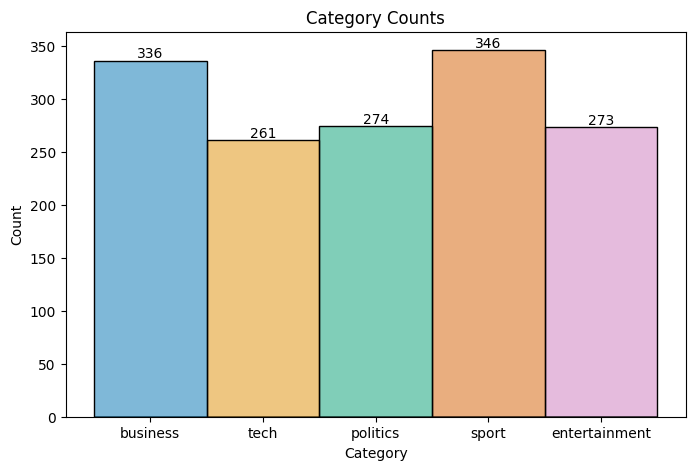

In [7]:
#-------------------- Helper functions for histogram count annotation -----------------------------
def add_histogram_values(ax): [ax.bar_label(remove_0_tags_for_histograms(b)) for b in ax.containers]
def remove_0_tags_for_histograms(ax_container):
    ind = np.where(ax_container.datavalues>0)[0]    
    ax_container.datavalues = ax_container.datavalues[ind]
    ax_container.patches = [ax_container.patches[i] for i in ind]
    return ax_container
#---------------------------------------------------------------------------------------------------
print('Number of articles per topic:')
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_df,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts');
add_histogram_values(ax)
C = pd.DataFrame(train_df['Category'].value_counts())
C

What categories contain most of the repeated Text?


/var/folders/gy/2ly271h95f334wv2rlrv6y4w0000gn/T/ipykernel_13697/857472380.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax2 = sns.histplot(


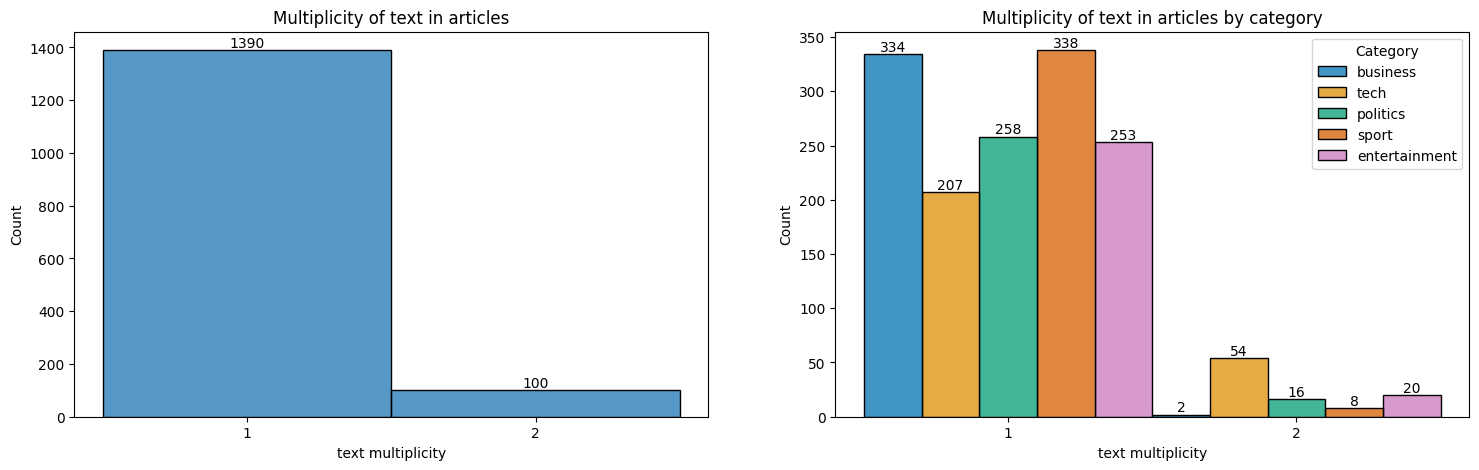

In [8]:
# Add column with multiplicity (note: leave it as a string for a prettier plot)
train_df['text multiplicity'] = train_df.groupby('Text')['Text'].transform('count').astype(str) 

print('What categories contain most of the repeated Text?')
fig, ax = plt.subplots(ncols=2,figsize=(18, 5))
# Histogram showing repeated text multiplicity in training dataframe
ax2 = sns.histplot(
    ax = ax[0],
    data = train_df,
    x='text multiplicity',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles');
add_histogram_values(ax[0])
# Same histogram, by Category
ax2 = sns.histplot(
    ax = ax[1],
    data = train_df,
    x='text multiplicity',
    hue = 'Category',
    palette = 'colorblind',
    multiple = 'dodge',
    legend = True,
    ).set(
        title = 'Multiplicity of text in articles by category');
add_histogram_values(ax[1])

In [9]:
train_df

,ArticleId,Text,Category,text multiplicity
0,1833,worldcom ex-boss launches defence lawyers defe...,business,1
1,154,german business confidence slides german busin...,business,1
2,1101,bbc poll indicates economic gloom citizens in ...,business,1
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,1
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,1
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,1
1487,1590,weak dollar hits reuters revenues at media gro...,business,1
1488,1587,apple ipod family expands market apple has exp...,tech,1


In [10]:
# Check how many categories are in each repeated text group
print('The maximum number of different categories assigned to repeated texts is: {}'.format(\
train_df[train_df['text multiplicity']!='1'].groupby('Text')['Category'].nunique().max()))

The maximum number of different categories assigned to repeated texts is: 1


Number of articles per topic (without duplicates):


,Category
sport,342
business,335
politics,266
entertainment,263
tech,234


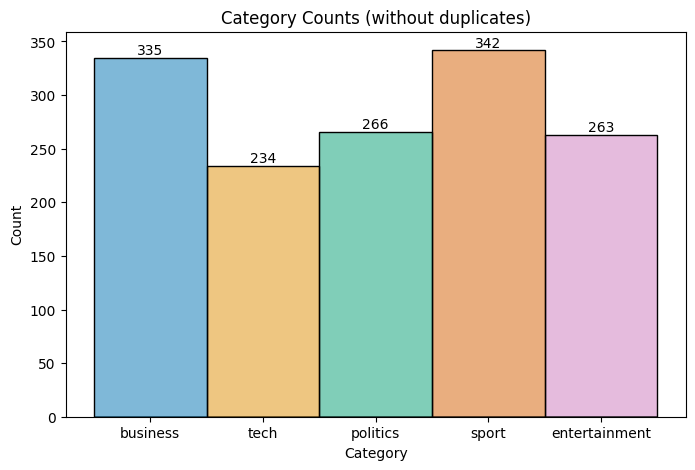

In [11]:
train_df = train_df.drop_duplicates(subset=['Text'])
print('Number of articles per topic (without duplicates):')
fig, ax = plt.subplots(figsize=(8, 5))
ax2 = sns.histplot(
    data = train_df,
    x = 'Category',
    hue = 'Category',
    palette = 'colorblind',
    legend = False,
    ).set(
        title = 'Category Counts (without duplicates)');
add_histogram_values(ax)
pd.DataFrame(train_df['Category'].value_counts())

In [12]:
print('*'*40)
print('Sample text:')
print('*'*40)
print(train_df['Text'][0])

print('\n'+'*'*40)
print('Frequency of punctuation marks in sample text:')
print('*'*40)
[print("  {} is {} times".format(c,train_df['Text'][0].count(c))) for c in ['.',',',';','?',':','!','"',"'",")","("]];

from collections import Counter
print('\n'+'*'*40)
print('Most common words in sample text:')
print('*'*40)
for word, count in Counter(train_df['Text'][0].split()).most_common(5):
    print("  '{}' is {} times".format(word, count))

****************************************
Sample text:
****************************************
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she sa

In [13]:
import re
def clean_text(df,keep_dots=False):
    """ cleans the column 'Text' in a DataFrame"""
    if keep_dots:
        clean_method = lambda x: clean_string(x,True)
    else:
        clean_method = clean_string
                
    try: # DataFrame
        return df['Text'].apply(clean_method)
    except KeyError: # Series
        return df.apply(clean_method)
    
def clean_string(s,keep_dots=False):
    """Cleans a string"""
    s = re.sub("\d+", " number ", s) # change numbers to word " number "
    if keep_dots:
        s = s.translate(s.maketrans("£,;:-", "$    ","()+-*!?%")) # replace £ with $ and remove punctuation       
    else:
        s = s.translate(s.maketrans("£.,;:-", "$     ","()+-*!?%")) # replace £ with $ and remove punctuation        
    s = s.replace("$ number", "money")
    s = s.replace("number bn", "money")
    s = s.replace("money bn", "money")
    s = s.replace("money   money", "money")
    s = s.replace("money money", "money")
    s = s.replace("number   number", "number")
    s = s.replace("number number", "number")
    return s

In [14]:
# Clean training set
pd.options.mode.chained_assignment = None
train_df['Text']=clean_text(train_df)
pd.options.mode.chained_assignment = "warn"

print('*** 3 Sample texts after cleaning: ***')
[print(train_df['Text'][i]+'\n') for i in range(3)];

*** 3 Sample texts after cleaning: ***
worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness   cynthia cooper  worldcom s exhead of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in  number   her warnings led to the collapse of the firm following the discovery of an money accounting fraud  mr ebbers has pleaded not guilty to charges of fraud and conspiracy   prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates  but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early  number  and  number   she said andersen had given a  green light  to the procedures

In [35]:
pd.options.mode.chained_assignment = None
train_df['word count'] = train_df['Text'].apply(lambda row: len(row.split()))
train_df['char count'] = train_df['Text'].apply(lambda row: len(row))
pd.options.mode.chained_assignment = "warn"
print('Training set including number of word and number of characters per entry:')
train_df

Training set including number of word and number of characters per entry:


,ArticleId,Text,Category,word count,char count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,1866
1,154,german business confidence slides german busin...,business,325,2016
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,3104
3,1976,lifestyle governs mobile choice faster bett...,tech,634,3618
4,917,enron bosses in $168m payout eighteen former e...,business,355,2190
...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,223,1266
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,558,3111
1487,1590,weak dollar hits reuters revenues at media gro...,business,237,1370
1488,1587,apple ipod family expands market apple has exp...,tech,560,3242


Statistics about characters and word count in training set


/var/folders/gy/2ly271h95f334wv2rlrv6y4w0000gn/T/ipykernel_13697/3205653549.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


,ArticleId,word count,char count
count,1440.000000,1440.000000,1440.000000
mean,1118.146528,385.036806,2263.959028
std,642.822120,211.599565,1221.994692
min,2.000000,90.000000,507.000000
25%,560.750000,253.000000,1480.000000
50%,1111.000000,337.500000,1995.000000
75%,1681.250000,468.250000,2789.500000
max,2224.000000,3352.000000,18769.000000


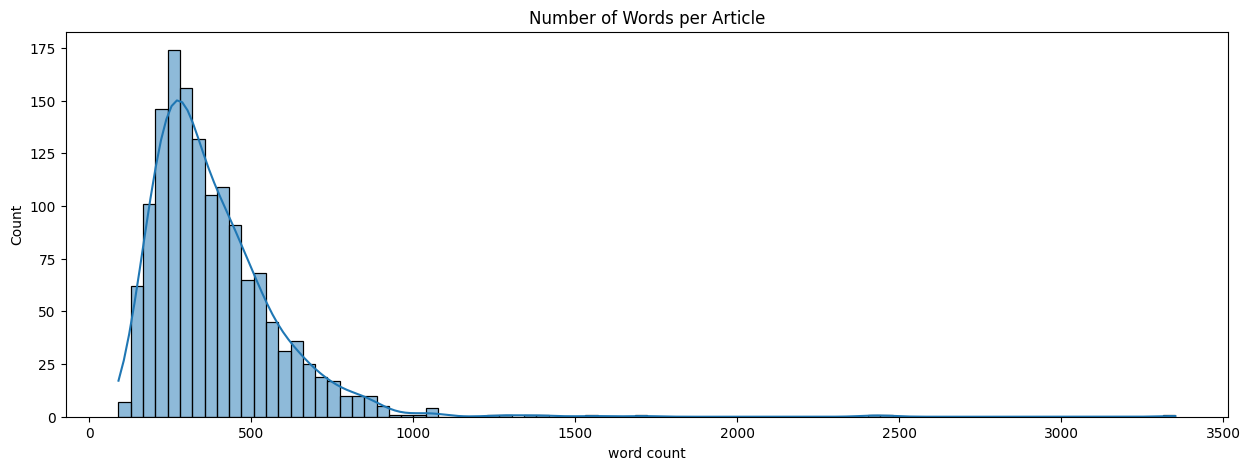

In [16]:
print('Statistics about characters and word count in training set')

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_df, 
    x = 'word count',
    palette = 'colorblind',
    kde=True,
    ).set(
        title = 'Number of Words per Article');
train_df.describe()

In [17]:
print('Word count statistics by category:')
G = train_df[['Category','word count']].groupby('Category')
G.describe()

Word count statistics by category:


word count                                                \
                   count        mean         std    min     25%    50%   
Category                                                                 
business           335.0  333.597015  132.663441  146.0  252.50  305.0   
entertainment      263.0  335.737643  204.777862  143.0  230.00  274.0   
politics           266.0  449.210526  260.855416   90.0  318.25  441.5   
sport              342.0  338.292398  187.036142  116.0  214.25  296.5   
tech               234.0  509.457265  213.427597  185.0  344.25  462.5   

                               
                  75%     max  
Category                       
business       388.50   907.0  
entertainment  380.00  2450.0  
politics       525.50  3352.0  
sport          417.75  1707.0  
tech           631.75  1557.0

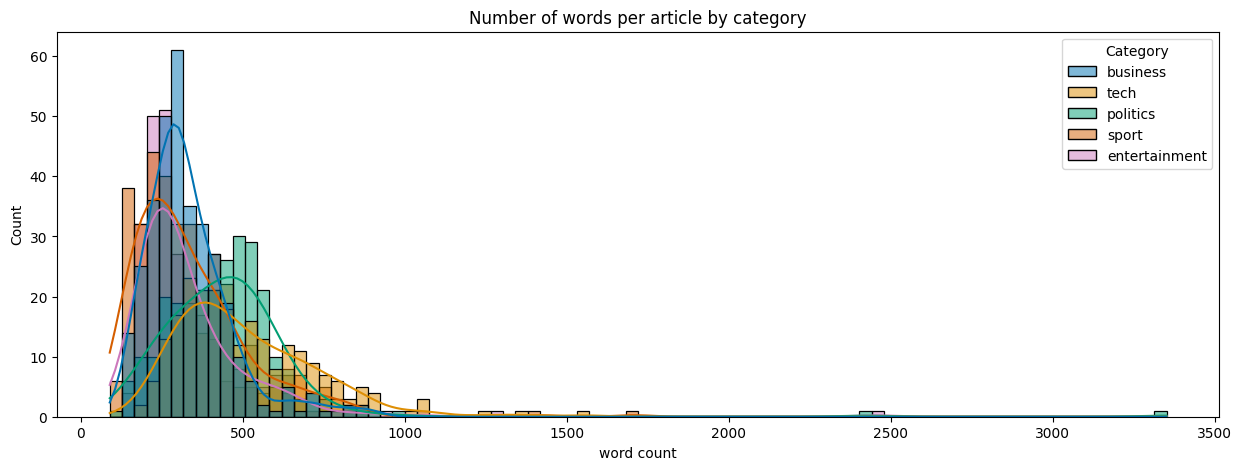

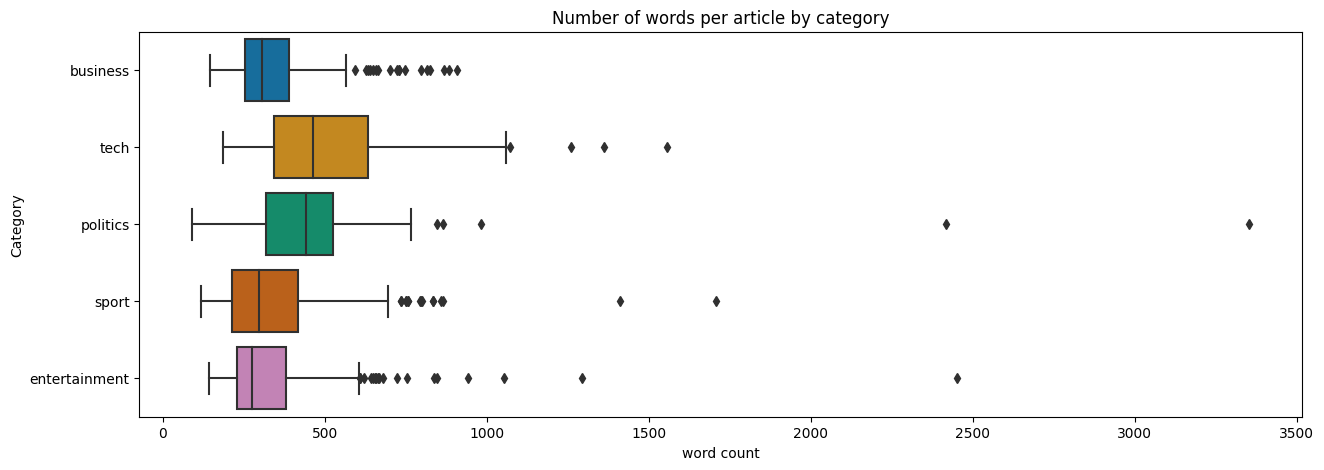

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(
    data = train_df, 
    x = 'word count',
    palette = 'colorblind',
    kde=True,
    hue = 'Category'
    ).set(
        title = 'Number of words per article by category');

# words per category
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(
    data = train_df, 
    x = 'word count', 
    y = 'Category',
    palette = 'colorblind'
    ).set(
        title = 'Number of words per article by category');

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer() 
WC=cv.fit_transform(train_df['Text'])
print('There are {} documents in the training set.'.format(len(train_df)))
print('There are {} different words in the training set.'.format(WC.shape[1]))
print('The sparse Matrix WC has size {} and its sparsity is {:.2f}%. '.format(WC.shape,100*(1-WC.count_nonzero()/np.prod(WC.shape))))
print('\nCorresponding DataFrame to WC:')
counts_df = pd.DataFrame(WC.A,columns=cv.get_feature_names_out ())
counts_df

There are 1440 documents in the training set.
There are 25277 different words in the training set.
The sparse Matrix WC has size (1440, 25277) and its sparsity is 99.23%. 

Corresponding DataFrame to WC:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1436,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1438,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
print('The most popular words amog all documents are are:')
print('\nword  count')
print(counts_df.sum().sort_values().tail())

The most popular words amog all documents are are:

word  count
in     11365
and    11931
of     12562
to     15998
the    33919
dtype: int64


In [21]:
# Include category column into word count
counts_df['_category_']=train_df['Category']

print('Word count by category:')
G = counts_df.groupby('_category_').sum()
G

Word count by category:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
_category_,,,,,,,,,,,,,,,,,,,,,
business,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
entertainment,0,0,1,0,0,0,0,0,0,0,...,0,3,0,1,1,0,0,2,0,3
politics,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,3,0,0
sport,0,3,0,0,3,0,1,0,1,0,...,0,1,0,1,0,0,1,1,1,1
tech,0,0,0,3,0,4,0,0,1,1,...,1,0,2,0,0,2,0,1,0,0


In [22]:
is_unique = G.astype(bool).sum(axis=0)==1

total_word_count = G.sum(axis=0)

a = total_word_count[is_unique]
b = G.idxmax(axis=0)[is_unique]
c = cv.get_feature_names_out ()[is_unique]

unique_words =  pd.DataFrame(data=zip(a,b),index=c,columns=['unique word count','Category'])
print('Unique words per category:')
unique_words.groupby('Category').describe()

Unique words per category:


unique word count                                              
                          count      mean       std  min  25%  50%  75%   max
Category                                                                     
business                 2779.0  1.391868  1.035416  1.0  1.0  1.0  1.0  13.0
entertainment            2253.0  1.343098  1.063229  1.0  1.0  1.0  1.0  12.0
politics                 2009.0  1.428074  1.278043  1.0  1.0  1.0  1.0  28.0
sport                    2872.0  1.362813  1.093336  1.0  1.0  1.0  1.0  24.0
tech                     2149.0  1.396929  1.195589  1.0  1.0  1.0  1.0  18.0

In [23]:

print('Top 10 Unique words and their count per category:')
C = unique_words.groupby('Category')
U = C.max()
U['top unique word'] = C.idxmax().iloc[:,0]
U
for category,g, in C:
    print('\nCategory: ',category,'\n',g['unique word count'].nlargest(10).to_markdown())  

Top 10 Unique words and their count per category:

Category:  business 
 |            |   unique word count |
|:-----------|--------------------:|
| qantas     |                  13 |
| monsanto   |                  10 |
| ufj        |                  10 |
| arnesen    |                   9 |
| bofra      |                   9 |
| jol        |                   9 |
| pernod     |                   9 |
| ssl        |                   9 |
| bombardier |                   8 |
| greer      |                   8 |

Category:  entertainment 
 |            |   unique word count |
|:-----------|--------------------:|
| ahold      |                  12 |
| hailey     |                  12 |
| carnival   |                  11 |
| roundabout |                  11 |
| conti      |                  10 |
| elgindy    |                  10 |
| painkiller |                  10 |
| absa       |                   9 |
| binge      |                   9 |
| purushotma |                   9 |

Category: 

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer() 
WC2 = tfidf_transformer.fit_transform(WC)

tfidf_df = pd.DataFrame(WC2.A,columns = cv.get_feature_names_out ())
print('WC2 matrix representation:')
tfidf_df

WC2 matrix representation:


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aaron,abacus,...,zonealarm,zones,zoom,zooms,zooropa,zorro,zuluaga,zurich,zutons,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
print('Raking of word scores in WC2:')
print('\n->column sum:')
print(tfidf_df.sum().sort_values())

Raking of word scores in WC2:

->column sum:
ni               0.012277
whining          0.012277
consciences      0.012277
uni              0.012277
unglamorous      0.012277
                  ...    
in             105.870227
and            106.016738
of             111.841852
to             142.631549
the            304.578104
Length: 25277, dtype: float64


In [26]:
print("Weights given to words by idf:")
pd.DataFrame(tfidf_transformer.idf_,
             cv.get_feature_names_out (),
             columns=["idf_weights"]).sort_values(by="idf_weights")

Weights given to words by idf:


,idf_weights
the,1.000000
to,1.004172
of,1.007663
in,1.008362
and,1.010464
...,...
fascination,7.579945
fascinating,7.579945
fascinate,7.579945
fastow,7.579945


Subset of the words that are in all categories (universal words):


,#of Articles with this word
count,3920.00000
mean,57.88801
std,125.26236
min,5.00000
25%,14.00000
50%,24.00000
75%,52.00000
max,1440.00000


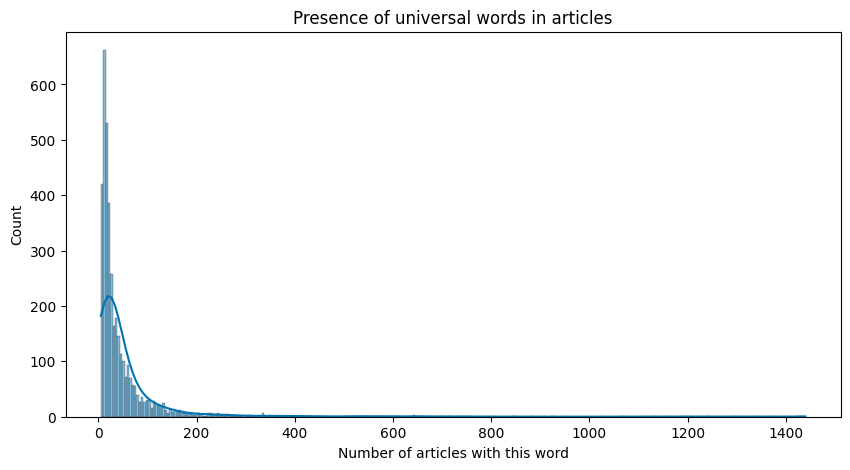

In [27]:
# Divide the words into 3 categories (unique,intermideate,universal) and merge them into a dataframe with column type:

print("Subset of the words that are in all categories (universal words):")
is_in_all_cats = G.astype(bool).sum(axis=0)==5
universal_words = pd.DataFrame(WC.getnnz(axis=0)[is_in_all_cats], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[is_in_all_cats]._data,
                               columns=['#of Articles with this word'])


fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
sns.histplot(
    ax=axs,
    data = universal_words, 
    legend = False,
    palette = 'colorblind',
    kde = True,
    ).set(
        title = 'Presence of universal words in articles',
        xlabel='Number of articles with this word');
universal_words.describe()

In [28]:
print('These are the 50 most common universal words:')
print(universal_words.iloc[:,0].nlargest(50))
print("\nRemark: The word money is found in {} articles".format(universal_words.loc['money'][0]))

These are the 50 most common universal words:
the       1440
to        1434
of        1429
in        1428
and       1425
number    1370
for       1335
on        1296
it        1246
is        1239
said      1226
with      1202
that      1194
has       1185
was       1157
at        1135
be        1113
by        1113
as        1074
have      1073
but       1069
from      1024
will       949
an         927
are        922
he         910
not        885
this       850
which      850
been       844
had        803
also       792
they       752
would      742
their      733
up         732
who        719
were       714
more       701
after      662
one        659
his        652
its        648
we         646
year       644
new        643
out        642
about      623
there      609
over       604
Name: #of Articles with this word, dtype: int64

Remark: The word money is found in 564 articles



Presence of words in articles by word type:



#of Articles with this word                                    \
                                   count       mean         std  min   25%   
type                                                                         
intermediate                      9295.0   4.328564    3.202857  1.0   2.0   
unique                           12062.0   1.103465    0.369969  1.0   1.0   
universal                         3920.0  57.888010  125.262360  5.0  14.0   

                                  
               50%   75%     max  
type                              
intermediate   3.0   5.0    47.0  
unique         1.0   1.0     9.0  
universal     24.0  52.0  1440.0

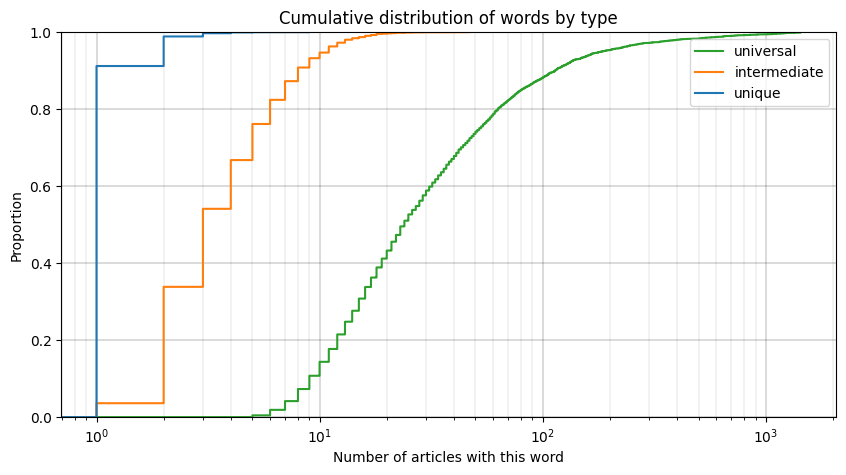

In [29]:
# Compute which words are unique, intermediate or universal

universal_words['type']='universal'
is_interm_freq_word = ~is_in_all_cats & ~is_unique
intermediate_words =  pd.DataFrame(WC.getnnz(axis=0)[is_interm_freq_word], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[is_interm_freq_word]._data,
                               columns=['#of Articles with this word'])
intermediate_words['type']='intermediate'

unique_words =  pd.DataFrame(WC.getnnz(axis=0)[is_unique], # nnz = number of nonzero entries per column (count of articles with word)
                               index=G.columns[is_unique]._data,
                               columns=['#of Articles with this word'])
unique_words['type']='unique' #defined in a previous cell.

word_types = pd.concat([unique_words,intermediate_words,universal_words],axis=0)


fig, axs = plt.subplots(ncols=1,figsize=(10, 5))
k=0
hue_order=['unique','intermediate','universal']
s=sns.ecdfplot(data = word_types,
             x= '#of Articles with this word',
             hue = "type",
             hue_order=hue_order,
             legend = False,                
             log_scale=(True,False),
#              label = hue_order
            ).set(
        title = 'Cumulative distribution of words by type',
        xlabel='Number of articles with this word');

axs.grid(visible=True, which='major', color='black', linewidth=0.2)
axs.grid(visible=True, which='minor', color='black', linewidth=0.075)
axs.legend(labels=hue_order[::-1])
word_types = word_types.groupby('type')
print('\nPresence of words in articles by word type:\n')
word_types.describe()

The word 'money' is of universal type, found in 564 articles.
Boxplots of word count per category for chosen words:
The word 'number' is of universal type, found in 1370 articles.
Boxplots of word count per category for chosen words:


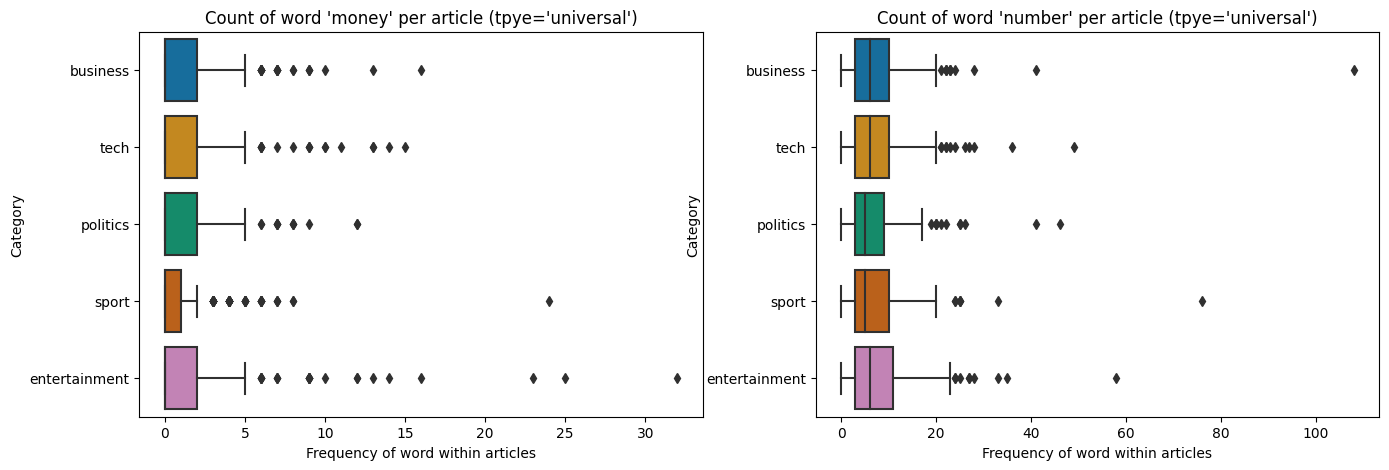

In [30]:
def get_word_type_and_count(word:str, word_types:pd.DataFrame):
    """ Returns a pandas series with word type and #of Articles with this word"""
    for word_type, group_df in word_types:
        try:
            return group_df.loc[word,:]
        except KeyError:
            pass
def print_word_type_and_count(word:str, word_types:pd.DataFrame):
    word_info = get_word_type_and_count(word, word_types)
    print("The word '{}' is of {} type, found in {} articles.".format(
        word, word_info['type'], word_info['#of Articles with this word']))     

    print('Boxplots of word count per category for chosen words:')
fig, axs = plt.subplots(ncols=2,figsize=(16, 5));
words = ('money','number')
for i,word in enumerate(words):
    word_type = get_word_type_and_count(word,word_types)['type'];
    print_word_type_and_count(word,word_types)
    
    sns.boxplot(        
        ax = axs[i],
        data = counts_df, 
        x = word, 
        y = '_category_',
        palette = 'colorblind',    
        ).set(
            title = "Count of word '{}' per article (tpye='{}')".format(word,word_type),
            xlabel = 'Frequency of word within articles',
            ylabel = 'Category');

Even though a different representation, we observe the same result. As a conclusion we decide to drop all articles with more than 1000 words in order to cut off outliers which will probably make our model more stable.

In [36]:
train_df = train_df[train_df['word count'] <= 1000]
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1425 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ArticleId   1425 non-null   int64 
 1   Text        1425 non-null   object
 2   Category    1425 non-null   object
 3   word count  1425 non-null   int64 
 4   char count  1425 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 66.8+ KB


In [45]:
import nltk
from nltk.corpus import stopwords
import re
import string
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# methods for cleaning the text column
def convert_to_lowercase(text):
    return text.lower()

def remove_punctuation(text):
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

def remove_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

def remove_short_words_and_stop_words(text):
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

def remove_multiple_spaces(text):
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

def clean_text(df, text_column):
    df[text_column] = df[text_column].apply(convert_to_lowercase)
    df[text_column] = df[text_column].apply(remove_punctuation)
    df[text_column] = df[text_column].apply(remove_numbers)
    df[text_column] = df[text_column].apply(remove_short_words_and_stop_words)
    df[text_column] = df[text_column].apply(remove_multiple_spaces)

In [49]:
clean_text(train_df, 'Text')

/var/folders/gy/2ly271h95f334wv2rlrv6y4w0000gn/T/ipykernel_13697/2070382039.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].apply(convert_to_lowercase)
/var/folders/gy/2ly271h95f334wv2rlrv6y4w0000gn/T/ipykernel_13697/2070382039.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].apply(remove_punctuation)
/var/folders/gy/2ly271h95f334wv2rlrv6y4w0000gn/T/ipykernel_13697/2070382039.py:33: SettingWithCopyWarning: 
A value is trying to be 

In [61]:
clean_text(test_df, 'Text')
test_df['Text'][0]

'qpr keeper day heads preston queens park rangers keeper chris day set join preston month loan day displaced arrival simon royce second month loan charlton qpr also signed italian generoso rossi manager ian holloway said might say risk recalled month simon royce recalled charlton irons fire yes couple others need day rangers contract expires summer meanwhile holloway hoping complete signing middlesbrough defender andy davies either permanently loan saturday match ipswich davies impressed recent loan spell loftus road holloway also chasing bristol city midfielder tom doherty'

In [52]:
#NMF Without Tuning 
tfidf_vectorizer = TfidfVectorizer()
train_tfidf = tfidf_vectorizer.fit_transform(train_df['Text'])
test_tfidf = tfidf_vectorizer.transform(test_df['Text'])

# NMF - 5 components since we have 5 categories
nmf_model = NMF(n_components=5)
train_nmf = nmf_model.fit_transform(train_tfidf)
test_nmf = nmf_model.transform(test_tfidf)

# Classifier
train_true = train_df['Category']
classifier = LogisticRegression()
classifier.fit(train_nmf, train_true)

# Prediction
train_pred = classifier.predict(train_nmf)
test_pred = classifier.predict(test_nmf)

train_accuracy = accuracy_score(train_true, train_pred)
print('Accuracy of training set without hyperparameter tuning: ', train_accuracy)

Accuracy of training set without hyperparameter tuning:  0.896140350877193


In [54]:
# Predicting Test Data
test_solution = pd.DataFrame(columns=['ArticleId', 'Category'])
test_solution['ArticleId'] = test_df['ArticleId']
test_solution['Category'] = test_pred
test_solution.head()

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [55]:
# NMF with hyperparameter Tuning 
def hyperparameter_tuning_NMF(df):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('nmf', NMF()),
        ('classifier', LogisticRegression())
    ])

    param_grid = {
        'tfidf__norm': ['l1', 'l2'],
        'tfidf__max_df': [0.95],
        'tfidf__min_df': [1, 2],
        'nmf__n_components': [5],
        'nmf__solver': ['mu'],
        'nmf__beta_loss': ['frobenius', 'kullback-leibler'],
        'nmf__l1_ratio': [0, 0.5, 1]
    }
    
    scoring = make_scorer(accuracy_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(df['Text'], df['Category'])
    
    return (grid_search.best_estimator_, grid_search.best_params_)

In [57]:
(best_model, best_params) = hyperparameter_tuning_NMF(train_df)
best_params = {key: [value] for key, value in best_params.items()}
pd.DataFrame(best_params)

,nmf__beta_loss,nmf__l1_ratio,nmf__n_components,nmf__solver,tfidf__max_df,tfidf__min_df,tfidf__norm
0,kullback-leibler,0,5,mu,0.95,2,l2


In [69]:
train_pred = best_model.predict(train_df['Text'])
train_true = train_df['Category']
train_accuracy = accuracy_score(train_true, train_pred)
print('Accuracy of training set with hyperparameter tuning: ', train_accuracy)

Accuracy of training set with hyperparameter tuning:  0.9592982456140351


In [83]:
test_pred = best_model.predict(test_df['Text'])
test_solution = pd.DataFrame(columns=['ArticleId', 'Category'])
test_solution['ArticleId'] = test_df['ArticleId']
test_solution['Category'] = test_pred
print(test_solution)
print(sample_solution_df)

     ArticleId       Category
0         1018          sport
1         1319           tech
2         1138          sport
3          459       business
4         1020          sport
..         ...            ...
730       1923       business
731        373  entertainment
732       1704       business
733        206       business
734        471       politics

[735 rows x 2 columns]
0              sport
1               tech
2           business
3      entertainment
4           politics
           ...      
730            sport
731             tech
732         business
733    entertainment
734         politics
Name: Category, Length: 735, dtype: object


In [81]:
test_accuracy = accuracy_score(sample_solution_df, test_pred)
print('Accuracy of training set with hyperparameter tuning: ', test_accuracy)

Accuracy of training set with hyperparameter tuning:  0.9318367346938775
